In [42]:
import pickle
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from numba import njit
from sklearn.decomposition import TruncatedSVD

In [32]:
def vectorize_contact_matrix(contact_matrix, include_diag=True):
	"""
	Vectorizes the block-diagonal contact matrix using the upper triangle.
	
	Args:
		contact_matrix (ndarray): Square 4D block matrix of shape (chr_i, chr_j, loc_i, loc_j).
		include_diagonal (bool): Whether to include the diagonal in the vector.
	
	Returns:
		1D np.array of concatenated vectorized intra-chromosome contacts.
	"""
	vectorized = []

	for i in range(23):  # for each chromosome (diagonal block)
	# note: assuming no INTER-chromosomal contact blocks
		block = np.array(contact_matrix[i][i])
		length = block.shape[0]  # number of loci

		k = 1 # Default is exclude diagonal
		if include_diag:
			k = 0
		triu_indices = np.triu_indices(length, k=k)
		upper_triangle = block[triu_indices]

		vectorized.append(upper_triangle)
		

	# concatenate all chromosomes into one vector in row-major style
	return np.concatenate(vectorized)



In [ ]:
'''
def get_exponential_distance_weights(chr_lens, alpha=0.9):
    """
    Create weights for vectorized upper-triangular contact matrices (including diagonal),
    where weights grow exponentially with distance from the diagonal.

    Args:
        chr_lens (list): list of chromosome lengths (i.e., number of loci per chromosome).
        alpha (float): exponential base; weight = alpha^distance from diagonal (smaller alpha = faster decay).

    Returns:
        weights (np.array): concatenated weights matching the vectorized contact vector.
    """
    weights = []

    for L in chr_lens:
        # Get upper triangle indices including diagonal
        i, j = np.triu_indices(L, k=0)
        dists = np.abs(j - i)  # distance from diagonal: 0, 1, 2, ...
        w = alpha ** dists     # exponential decay: 1, alpha, alpha^2, ...
        weights.append(w)

    return np.concatenate(weights)
'''

In [6]:
my_filepath = "contact_dict_bin_cells_filtered.pkl"

In [7]:
# load data nested dictionary data file 
# Format contact_dict = {cell_type: {cell_name: dataframe, ...}, ...}
# E.g. {'GM12878': {'cell1.txt': contact_matrix1, 'cell2.txt': contact_matrix2},
#     'K562': {'cell3.txt': contact_matrix3}, ...}
with open(my_filepath, "rb") as f:
	contact_dict = pickle.load(f)

In [33]:
def get_X_labels_lens(contact_dict, include_diag=True):
	"""
	Get overall matrix X for applying dimension reduction
	rows = number of cells (observations), 
	columns = number of contact intersections/"pixels" (features)

	Output: X (np array): (num_cells, num_features)
		cell_labels (list of tuples): (cell_type, cell_name) for each row = cell in X
		labels (list): type of each cell
		chr_lens (list): length (number of loci) for each chromosome
	"""
	# Master matrix and labels
	all_vectors = []
	cell_labels = []
	labels = []
	chr_lens = []

	first_cell = True
	for cell_type, cells in contact_dict.items():
		for cell_name, matrix in cells.items():
			vec = vectorize_contact_matrix(matrix, include_diag=include_diag)
			all_vectors.append(vec)
			cell_labels.append((cell_type, cell_name))
			labels.append(cell_type)	# for coloring cell points by their type
			
			if first_cell: # only need to find chromosome lengths for one cell
				for i in range(23):  # for each chromosome (diagonal block)
					block = np.array(matrix[i][i])
					chr_lens.append(block.shape[0])
				first_cell = False

	# convert to np array for efficient masking. Else, kernel will crash
	labels = np.array(labels)
				
	# Stack into a matrix: each row is a vectorized cell
	X = np.vstack(all_vectors)
	return(X, cell_labels, labels, chr_lens)

In [ ]:
'''
alpha = 0.9
weights = get_exponential_distance_weights(chr_lens, alpha=alpha)
print("Weights shape:", weights.shape)  # should match X.shape[1]
'''

Weights shape: (239611,)


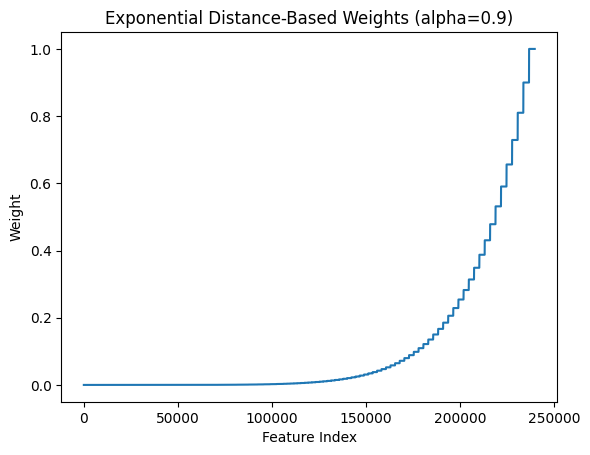

In [19]:
plt.plot(np.sort(weights))
plt.title(f"Exponential Distance-Based Weights (alpha={alpha})")
plt.xlabel("Feature Index")
plt.ylabel("Weight")
plt.show()

In [34]:
def get_exponential_distance_weights(chr_lens, alpha=0.9):
    """
        Create weights for vectorized upper-triangular contact matrices (including diagonal),
        where weights grow exponentially with distance from the diagonal.

        Args:
            chr_lens (list): list of chromosome lengths (i.e., number of loci per chromosome).
            alpha (float): exponential base; weight = alpha^distance from diagonal (smaller alpha = faster decay).

        Returns:
            weights (np.array): concatenated weights matching the vectorized contact vector.
        """
    weights = []
    for L in chr_lens:
        # Get upper triangle indices including diagonal
        i, j = np.triu_indices(L, k=0)
        dists = np.abs(j - i)  # distance from diagonal: 0, 1, 2, ...
        w = alpha ** dists     # exponential decay: 1, alpha, alpha^2, ...
        weights.append(w)

    return np.concatenate(weights)

In [35]:
if __name__ == "__main__":	# don't run if imported
	X, cell_labels, labels, chr_lens = get_X_labels_lens(contact_dict)
	print("X shape:", X.shape)	# Unfiltered: 2611 cell files, 236562 loci contact pairs
	# display(X)
	
alpha = 0.9 
weights = get_exponential_distance_weights(chr_lens, alpha=alpha)

X shape: (1958, 239611)


In [38]:
@njit

def weighted_euclidean_numba(x, y, w):
    return np.sqrt(np.sum(w * (x - y) ** 2))

def weighted_euclidean(x, y):
    return weighted_euclidean_numba(x, y, weights)

In [39]:
print(chr_lens)

[250, 244, 198, 192, 181, 172, 160, 147, 142, 136, 135, 134, 116, 108, 103, 91, 82, 79, 60, 63, 49, 52, 155]


In [40]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric=weighted_euclidean,
    random_state=42,
)

X_umap = reducer.fit_transform(X)


c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


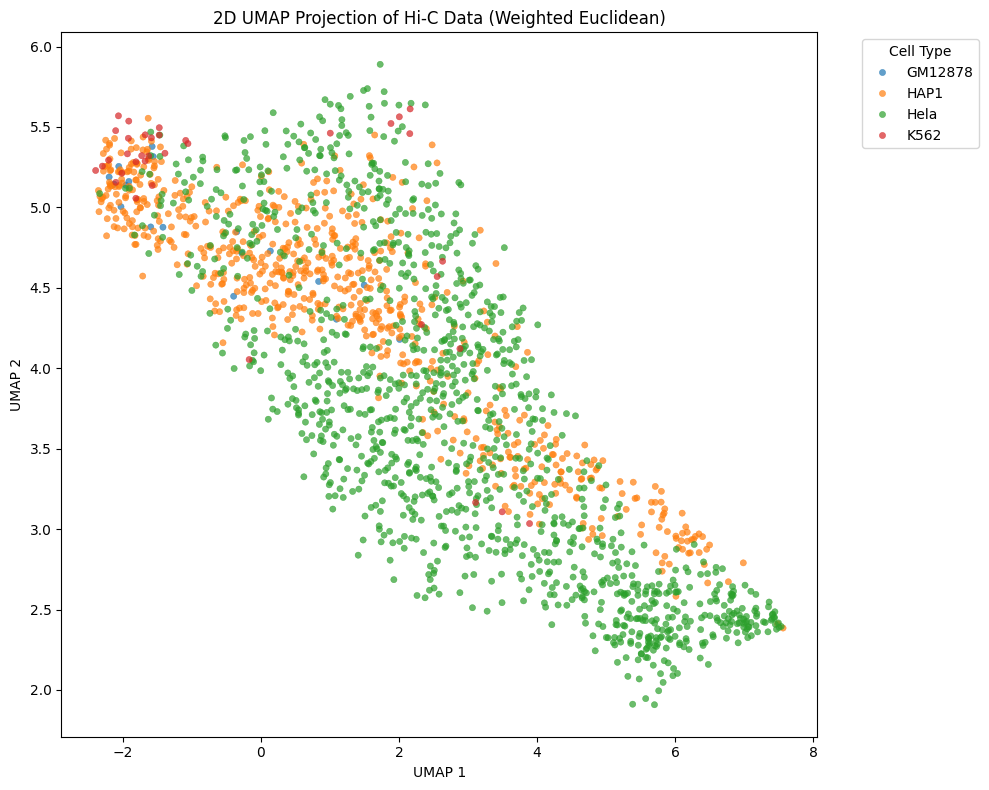

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure `labels` is a 1D array of strings (e.g., ["HAP1", "K562", ...])
# If not already done:
labels = np.array([label[0] for label in cell_labels])

# Unique cell types and color mapping
unique_labels = np.unique(labels)
palette = sns.color_palette("tab10", len(unique_labels))
color_map = dict(zip(unique_labels, palette))
colors = [color_map[label] for label in labels]

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels,
                palette=color_map, s=20, alpha=0.7, edgecolor=None)

plt.title("2D UMAP Projection of Hi-C Data (Weighted Euclidean)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
X_svd = TruncatedSVD(n_components=300, random_state=42).fit_transform(X)


In [44]:
print("Reduced shape:", X_svd.shape)

Reduced shape: (1958, 300)


In [45]:
alpha = 0.99  # smaller alpha = more weight to later PCs
weights = alpha ** np.arange(X_svd.shape[1])[::-1]

In [46]:
from numba import njit

@njit
def weighted_euclidean_numba(x, y, w):
    return np.sqrt(np.sum(w * (x - y) ** 2))

def weighted_euclidean(x, y):
    return weighted_euclidean_numba(x, y, weights)

In [47]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric=weighted_euclidean,
    random_state=42,
)

X_umap_svd = reducer.fit_transform(X_svd)

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


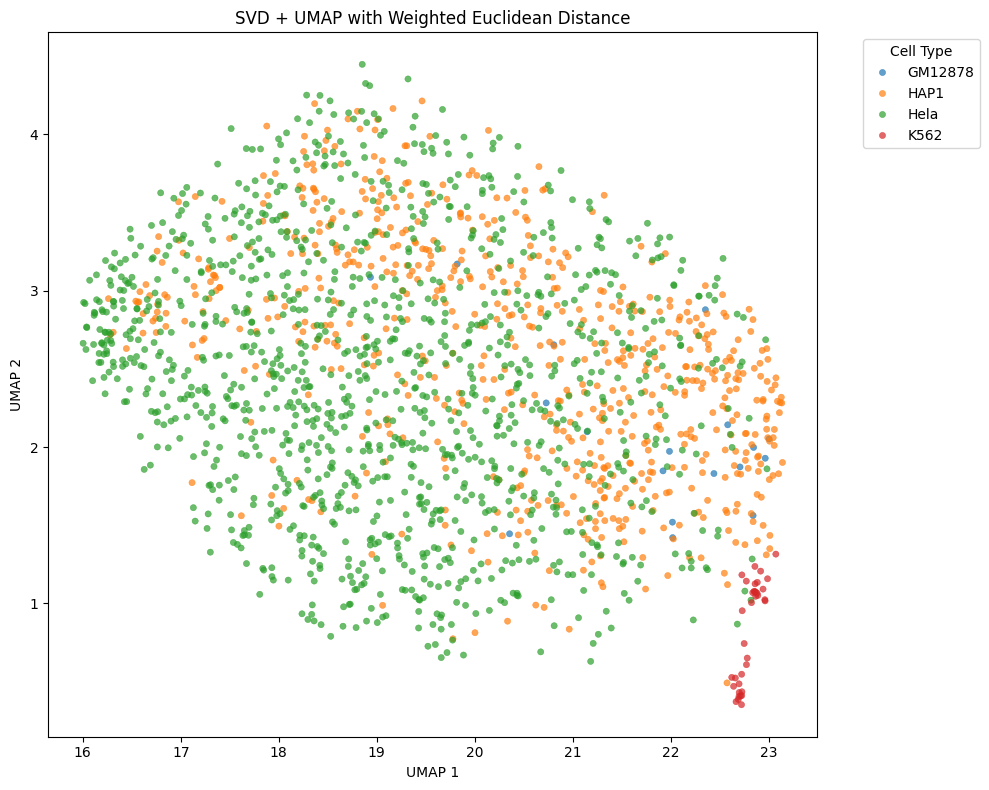

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_labels = np.unique(labels)
palette = sns.color_palette("tab10", len(unique_labels))
color_map = dict(zip(unique_labels, palette))

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap_svd[:, 0], y=X_umap_svd[:, 1], hue=labels,
                palette=color_map, s=20, alpha=0.7, edgecolor=None)
plt.title("SVD + UMAP with Weighted Euclidean Distance")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3D

In [49]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,  # 👈 3D projection
    metric=weighted_euclidean,
    random_state=42,
)

X_umap_svd_3d = reducer.fit_transform(X_svd)

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1857: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


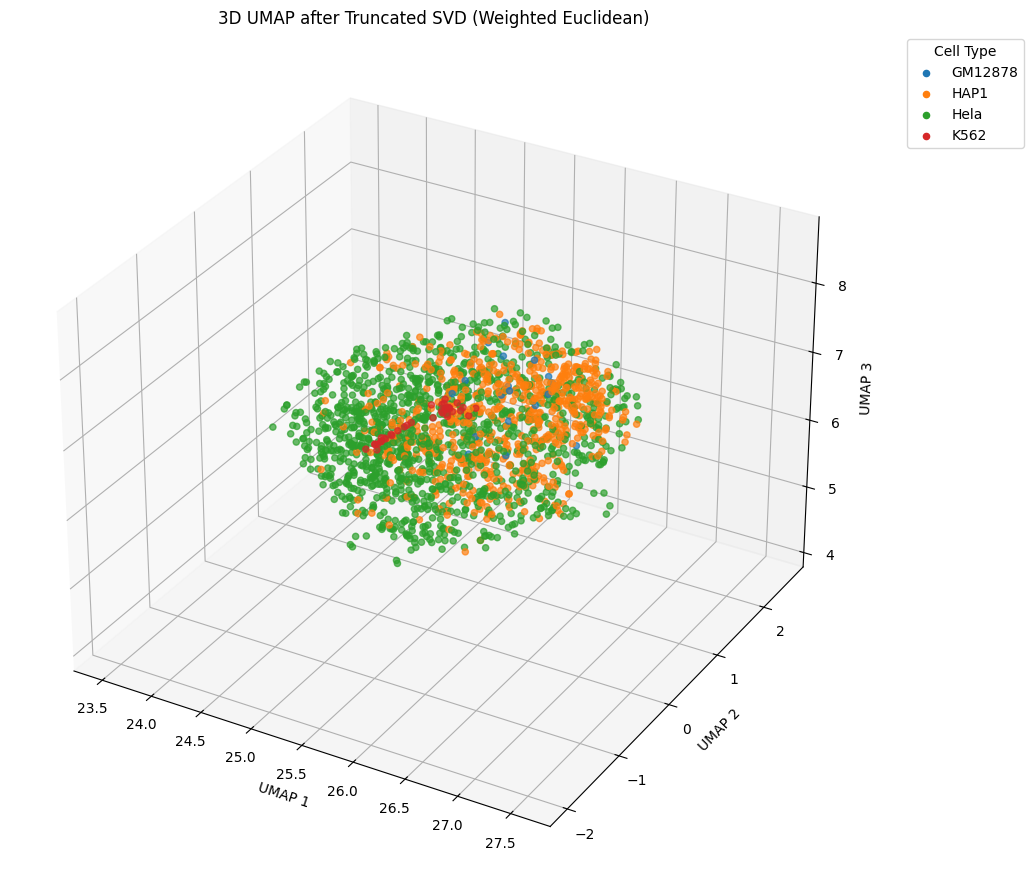

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
import seaborn as sns

# Set up color map
unique_labels = np.unique(labels)
palette = sns.color_palette("tab10", len(unique_labels))
color_map = dict(zip(unique_labels, palette))
colors = [color_map[label] for label in labels]

# 3D Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_umap_svd_3d[:, 0], X_umap_svd_3d[:, 1], X_umap_svd_3d[:, 2],
                c=colors, alpha=0.7, s=20)

# Add legend manually
for label in unique_labels:
    ax.scatter([], [], [], color=color_map[label], label=label)
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("3D UMAP after Truncated SVD (Weighted Euclidean)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.tight_layout()
plt.show()
